[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<ipython-input-59-cfe22eca1529>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_balanced = data.groupby('expected_political_leaning').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)


Accuracy: 0.67


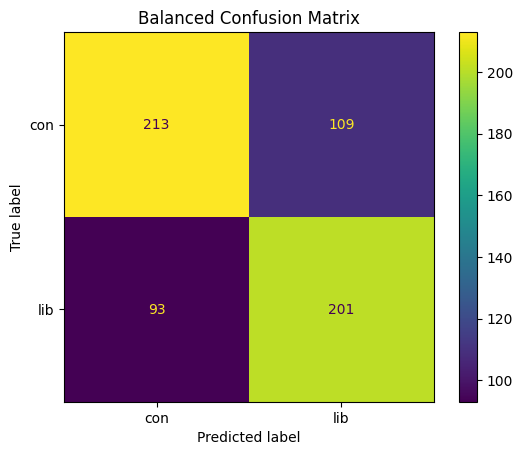

Precision: 0.65
Recall: 0.68
F1-score: 0.67
The party with the highest percentage is: Republican (93.00%)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("pre_processed_data.csv")

# tokenization (spliting text into words)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# builds the vocab
X_tfidf = tfidf_vectorizer.fit_transform(data['text'])
print(X_tfidf.toarray())


# combine TF-IDF features with upvote score
X = np.hstack([X_tfidf.toarray(), data['score'].values.reshape(-1, 1)])
# X = np.hstack(X_tfidf.toarray())

y = data['expected_political_leaning']

# # same num of samples
min_class_count = min(y.value_counts())
data_balanced = data.groupby('expected_political_leaning').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

X_balanced = np.hstack([
    tfidf_vectorizer.fit_transform(data_balanced['text']).toarray(),
    data_balanced['score'].values.reshape(-1, 1)
])
y_balanced = data_balanced['expected_political_leaning']

# classification
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# accuracy score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


# visualize the Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Balanced Confusion Matrix")
plt.show()

precision = precision_score(y_test, y_pred, pos_label='lib')
recall = recall_score(y_test, y_pred, pos_label='lib')
f1 = f1_score(y_test, y_pred, pos_label='lib')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")



def predict_paragraph(text, upvote_score=150):
    text_vector = tfidf_vectorizer.transform([text]).toarray()
    features = np.append(text_vector, upvote_score).reshape(1, -1)
    prediction = clf.predict(features)[0]
    return prediction


# file_path = "Insurance_top_posts.csv"
# file_path = "wallstreetbets_top_posts.csv"
file_path = "NonPoliticalTwitter_top_posts.csv"
data = pd.read_csv(file_path)

if 'text' not in data.columns:
    raise ValueError("The dataset must contain a 'text' column.")

data['predicted_political_leaning'] = data['text'].apply(lambda text: predict_paragraph(text))

data['predicted_political_leaning_label'] = data['predicted_political_leaning'].map({
    'lib': 'Democrat',
    'con': 'Republican'
})

leaning_percentage = data['predicted_political_leaning_label'].value_counts(normalize=True) * 100

highest_party = leaning_percentage.idxmax()
highest_percentage = leaning_percentage.max()

print(f"The party with the highest percentage is: {highest_party} ({highest_percentage:.2f}%)")

